# Portfolio Optimization Project

### CS/ECE/ISyE 524 — Introduction to Optimization — Fall 2024

### Project Members: Pawin Linmaneechote, Vincent Philavong, Jiajie Yao

## Table of Contents
1. [Introduction](#intro)  
2. [Mathematical Model](#math-model)  
    2.1. [Assumptions](#assumptions)  
    2.2. [Models](#models)  
        2.2.1. [Minimum Volatility Optimization Model with Diversification (QP)](#model-2-2-1)  
        2.2.2. [Markowitz Portfolio with Diversification (QP)](#model-2-2-2)  
        2.2.3. [Sharpe Ratio with Diversification (NLP)](#model-2-2-3)  
3. [Implementation](#solutions)  
    3.1. [Minimum Volatility Optimization Model Function (QP)](#func1)  
    3.2. [Markowitz Portfolio with Diversification Function (QP)](#func2)  
    3.3. [Sharpe Ratio with Diversification Function (NLP)](#func3)  
4. [Results and Discussion](#results)  
    4.1. [Data Preprocessing](#data-preprocessing)  
    4.2. [Returns Analysis](#returns-analysis)  
    4.3. [Covariances and Correlation](#covariances-correlation)  
    4.4. [Allocation Proportions for Sectors and Assets](#allocation-proportions)  
    4.5. [Cumulative Weight Distribution Analysis](#cumulative-weight-analysis)  
    4.6. [Diversification Sensitivity Analysis](#diversification-sensitivity)  
        4.6.1. [Portfolio Return Analysis with Diversification Penalty](#return-analysis)  
        4.6.2. [Portfolio Variance Analysis with Diversification Penalty](#variance-analysis)  
    4.7. [Efficient Frontier Analysis](#eff)  
    4.8. [Model Limitations](#limit)
6. [Conclusion](#conclusion)  
7. [Author Contributions](#contributions)  
8. [References](#references)

---

<a name="intro"></a>
# 1. Introduction #
Investing is about making smart decisions to balance the trade-offs between risk and reward. In this project, we explore portfolio optimization by analyzing financial data from Yahoo Finance. We’ve chosen five asset sectors - Technology, Financials, Healthcare, Communication Services, and Industrials - to build a diversified portfolio. This selection spreads risk across industries while aiming to capture each sector’s growth potential. The list of the stock sectors and the individual stocks can be seen below.
- Technology
    - Apple (AAPL)
    - Uber (UBER)
    - Microsoft (MSFT)
    - NVIDIA (NVDA)
    - Advanced Micro Devices (AMD)
- Financial
    - Discover (DFS)
    - JP Morgan (๋JPM)
    - Synchrony (SYF)
    - American Express (AXP)
    - Goldman Sachs (GS)
- Health Care
    - Pfizer (PFE)
    - Johnson & Johnson (JNJ)
    - Merck Sharp & Dohme (MRK)
    - United Health Group (UNH)
    - ABBVie (ABBV)
- Communication Services
    - Meta (META)
    - Google (GOOG)
    - Netflix (NFLX)
    - T-Mobile (TMUS)
    - The Walt Disney Services (DIS)
- Industrials
    - Caterpillar (CAT)
    - RTX Coorporation (RTX)
    - The Boeing Company (BA)
    - Union Pacific Corperation (UNP)
    - Eaton Corporation PLC (ETN)

Our project focuses on optimizing three models. The first model, also known as the Minimum Volitaty Optimization (MVO), addressing the challenge of balancing variance in addition to diversification by analyzing the performance and relationships between the selected stocks. The second, known as the, Markowitz Model, builds on the baseline by of the variance model by tranforming the model into a trade-off between returns, variance, and diversification, which we believe will give a better result for the allocations. For the third model, we introduce a Sharpe Ratio model, focusing on maximizing the Sharpe Ratio with diversification to evaluate the effeciency of the stock allocations.

Portfolio optimization has been a topic of interest for investors and researchers for decades. It’s rooted in the uncertainty of financial markets, where both short-term gains and long-term stability needed careful evaluation. The economist, Harry Markowitz, revolutionized this field in 1952 with his paper Portfolio Selection, introducing diversification as a way to reduce risk [1]. His work laid the groundwork for modern portfolio theory (MPT) and earned him a Nobel Prize. Yet, as markets continue to evolve, ongoing research is critical to adapting strategies for changing conditions like volatility, economic shifts, and new investor behaviors.

This report is structured into four sections: the Mathematical Model, where we define the decision variables, constraints, and objective function; the Solution, where we implement the model in Julia; Results and Discussion, where we present and interpret the outcomes; and the Conclusion, summarizing our findings and proposing future directions.

---

<a name="math-model"></a>
# 2. Mathematical Model

Portfolio optimization models can be designed in various ways by incorporating factors such as returns, variance, diversification, and other criteria. These models aim to provide practical insights for investors seeking to optimize their portfolios while understanding the implications of different investment strategies. Based on our data from Yahoo Finance, we can formulate distinct models tailored to achieve specific objectives. In the following sections, we will outline the assumptions and motivations behind each model.

---

<a name="assumptions"></a>
## 2.1. Assumptions

Our portfolio optimization relies on these key principles:

1. **Asset Returns**:
   - Assumed to follow a normal, stationary distribution, where historical returns represent future behavior.

2. **Risk (Variance)**:
   - Variance is constant over time, and asset correlations are accurately captured by historical data.

3. **Diversification**:
   - Portfolios benefit from spreading weights across assets, reducing unsystematic risk, with a trade-off between diversification and returns.

4. **Market Conditions**:
   - Markets are efficient, reflecting all available information.
   - No transaction costs, taxes, or liquidity constraints are considered.

5. **Model Parameters**:
   - Risk aversion $ \lambda $ is fixed, with non-negative asset weights summing to 1.

6. **Model Framework**:
   - MVO: Focuses on variance as the sole measure of risk.
   - Markowitz: Assumes linear risk-return relationships.
   - Sharpe: Balances risk and return via the Sharpe ratio.

7. **Market Dynamics**:
   - Assumes stable market volatility within a defined range.

8. **Investor Behavior**:
   - Models assume rational investors aiming to maximize returns while minimizing risk.

---

<a name="models"></a>
## 2.2 Mathematical Models   
Each model will have a different objective but will hold under these key frameworks:
1. **Diversification:**  
    A key challenge in portfolio optimization is ensuring adequate diversification to protect against sector-specific or asset-specific risks. The penalty factor $\gamma \sum_{i=1}^{n_{\text{assets}}} x_i^2$ encourages spreading the portfolio weights across multiple assets, thereby penalizing portfolios with excessive allocation to individual assets.
2. **Constraints:**  
   Real-world constraints, such as bounds on individual asset weights $(0.02 \leq x_{i} \leq 0.10)$ and limits on sector allocations $(0.10 \leq \sum_{i \in \text{sector } j} x_i \leq 0.40)$, ensure the portfolio adheres to practical investment guidelines. These constraints align with the typical requirements of institutional investors to balance regulatory, sectoral, and diversification limits.
3. **Flexibility through γ:**  
    The inclusion of the diversification penalty factor γ adds flexibility to the model, allowing users to tune the importance of diversification relative to risk minimization. For example:
    - A high γ value emphasizes diversification, favoring portfolios with evenly distributed weights.
    - A low γ value prioritizes risk minimization over diversification.

---

<a name="model-2-2-1"></a>
### 2.2.1 Minimum Volitaty Optimization Model with Diversification Term (QP)

The Minimum Volatility Optimization Model [3] with Diversification Term (QP) is a quadratic program (QP) motivated by the need to balance risk minimization and diversification. As a QP, the model optimizes a quadratic objective function (portfolio variance and diversification penalty) subject to linear constraints on asset weights and sector allocations. By incorporating practical constraints and a tunable diversification penalty, the model ensures that portfolios are robust, well-diversified, and aligned with real-world investment goals, while leveraging the efficiency and mathematical rigor of quadratic programming techniques.

#### Parameters:
- $\Sigma$: Covariance matrix of asset returns.
- $\mu$: Vector of expected returns for each asset.
- $\gamma$: Diversification penalty factor.
- $n_{assets}$: Number of assets in the portfolio
- $ \text{sector} $: Mapping of sectors to asset indices.


#### Decision Variables:

- $x_{\text{i}}:$ Percentage of the total budget allocated to asset $ i, \quad i \in \{1, 2,\ldots, n_{\text{assets}}\}. $

#### Constraints:  
1. Bounds on Asset Allocation: ensures an asset will only weigh 2% to 10% in a portfolio  
\begin{aligned}
0.02 \leq x_i \leq 0.10, \quad \forall i \in \{1, 2, \ldots, n_{\text{assets}}\}.
\end{aligned}
2. Budget Constraint: ensures the budget is 100% used
\begin{aligned}  
\sum_{i=1}^{n_{\text{assets}}} x_i = 1.
\end{aligned}
3. Sector Allocation Constraints: ensures each sector stays within 10% to 40%
\begin{aligned}
0.10 \leq \sum_{i \in \text{sector } j} x_i \leq 0.40, \quad \forall j \in \{1, 2, \ldots, n_{\text{sectors}}\}.
\end{aligned}

#### Objective Functions:
\begin{aligned}
\text{Minimize} \quad x^\top \Sigma x + \gamma \sum_{i=1}^{n_{\text{assets}}} x_i^2
\end{aligned}  
Where:
- $ x^\top \Sigma x $ : Portfolio variance (risk).  
- $ \sum_{i=1}^{n_{\text{assets}}} x_i^2 $ : Penalty term to promote diversification.


#### Final Model:
\begin{aligned}
\text{Minimize} \quad & x^\top \Sigma x + \gamma \sum_{i=1}^{n_{\text{assets}}} x_i^2 \\
\text{Subject to} \quad & \sum_{i=1}^{n_{\text{assets}}} x_i = 1, \\
& 0.02 \leq x_i \leq 0.1 \quad \forall i \in \{1, 2, \ldots, n_{\text{assets}}\}, \\
& 0.10 \leq \sum_{i \in \text{sector} j} x_i \leq 0.40 \quad \forall j \in \{1, 2, \ldots, n_{\text{sectors}}\}.
\end{aligned}

---

### 2.2.2 Markowitz Portfolio with Diversification (QP)

The Markowitz Portfolio with Diversification Model (QP) [4] is a sophisticated enhancement of the classical Markowitz framework. By adding a diversification penalty and introducing a risk aversion parameter, the model addresses the limitations of overly concentrated portfolios. Its quadratic programming (QP) formulation ensures efficient optimization while balancing return, risk, and diversification, making it a practical and robust tool for portfolio management.

#### Parameters:
- $\Sigma$: Covariance matrix of asset returns.
- $\mu$: Vector of expected returns for each asset.
- $\gamma$: Diversification penalty factor.
- $n_{assets}$: Number of assets in the portfolio
- $ \text{sector} $: Mapping of sectors to asset indices.
- $\lambda = 0.1 $: Risk aversion parameter that controls the trade-off between return and risk.


#### Decision Variables:

- $x_{\text{i}}:$ Percentage of the total budget allocated to asset $ i, \quad i \in \{1, 2,\ldots, n_{\text{assets}}\} $

#### Constraints:  
1. Bounds on Asset Allocation: ensures an asset will only weigh 2% to 10% in a portfolio  
\begin{aligned}
0.02 \leq x_i \leq 0.10, \quad \forall i \in \{1, 2, \ldots, n_{\text{assets}}\}.
\end{aligned}
2. Budget Constraint: ensures the budget is 100% used
\begin{aligned}  
\sum_{i=1}^{n_{\text{assets}}} x_i = 1.
\end{aligned}
3. Sector Allocation Constraints: ensures each sector stays within 10% to 40%
\begin{aligned}
0.10 \leq \sum_{i \in \text{sector } j} x_i \leq 0.40, \quad \forall j \in \{1, 2, \ldots, n_{\text{sectors}}\}.
\end{aligned}

#### Objective Function
\begin{aligned}
\text{Maximize} \quad \mu^\top x - \lambda (x^\top \Sigma x) - \gamma \sum_{i=1}^{n_{\text{assets}}} x_i^2
\end{aligned}
Where:
- $ \mu^\top x $ : Expected return of the portfolio.
- $ x^\top \Sigma x $ : Portfolio variance (risk).
- $ \sum_{i=1}^{n_{\text{assets}}} x_i^2 $ : Penalty term to promote diversification.

#### Final Model
\begin{aligned}
\text{Maximize} \quad & \mu^\top x - \lambda (x^\top \Sigma x) - \gamma \sum_{i=1}^{n_{\text{assets}}} x_i^2 \\
\text{Subject to} \quad & \sum_{i=1}^{n_{\text{assets}}} x_i = 1, \\
& 0.02 \leq x_i \leq 0.1 \quad \forall i \in \{1, 2, \ldots, n_{\text{assets}}\}, \\
& 0.10 \leq \sum_{i \in \text{sector} j} x_i \leq 0.40 \quad \forall j \in \{1, 2, \ldots, n_{\text{sectors}}\}.
\end{aligned}


<a name="model-2-2-3"></a>
### 2.2.3 Sharpe Ratio Model with Diversification (NLP)

The Sharpe Ratio with Diversification Model [2] is motivated by the need to construct a portfolio that maximizes risk-adjusted returns while ensuring adequate diversification. The model is formulated as a nonlinear programming (NLP) problem because the Sharpe ratio involves nonlinear terms such as the portfolio standard deviation $\sqrt{x^\top \Sigma x}$ in the denominator. 

#### Parameters:
- $\Sigma$: Covariance matrix of asset returns.
- $\mu$: Vector of expected returns for each asset.
- $\gamma$: Diversification penalty factor.
- $n_{assets}$: Number of assets in the portfolio
- $r_f$ Risk-free rate (set to 0 in this model)
- $ \text{sector} $: Mapping of sectors to asset indices.

#### Decision Variables:

- $x_{\text{i}}:$ Percentage of the total budget allocated to asset $ i, \quad i \in \{1, 2,\ldots, n_{\text{assets}}\} $

#### Constraints:  
1. Bounds on Asset Allocation: ensures an asset will only weigh 2% to 10% in a portfolio  
\begin{aligned}
0.02 \leq x_i \leq 0.10, \quad \forall i \in \{1, 2, \ldots, n_{\text{assets}}\}.
\end{aligned}
2. Budget Constraint: ensures the budget is 100% used
\begin{aligned}  
\sum_{i=1}^{n_{\text{assets}}} x_i = 1.
\end{aligned}
3. Sector Allocation Constraints: ensures each sector stays within 10% to 40%
\begin{aligned}
0.10 \leq \sum_{i \in \text{sector } j} x_i \leq 0.40, \quad \forall j \in \{1, 2, \ldots, n_{\text{sectors}}\}.
\end{aligned}

#### Objective Function
\begin{aligned}
\text{Maximize} \quad \frac{\mu^\top x - r_f}{\sqrt{x^\top \Sigma x}} - \gamma \sum_{i=1}^{n_{\text{assets}}} x_i^2
\end{aligned}
Where:
- $ \mu^\top x $ : Expected portfolio return.
- $ r_f $ : Risk-free rate.
- $ \sqrt{x^\top \Sigma x} $ : Portfolio standard deviation (risk).
- $ \gamma \sum_{i=1}^{n_{\text{assets}}} x_i^2 $ : Penalty term to encourage diversification.

#### Final Model
\begin{aligned}
\text{Maximize} \quad & \frac{\mu^\top x - r_f}{\sqrt{x^\top \Sigma x}} - \gamma \sum_{i=1}^{n_{\text{assets}}} x_i^2 \\
\text{Subject to} \quad 
& \sum_{i=1}^{n_{\text{assets}}} x_i = 1, \\
& 0.02 \leq x_i \leq 0.1 \quad \forall i \in \{1, 2, \ldots, n_{\text{assets}}\}, \\
& 0.10 \leq \sum_{i \in \text{sector} j} x_i \leq 0.40 \quad \forall j \in \{1, 2, \ldots, n_{\text{sectors}}\}.
\end{aligned}

---


<a name="solutions"></a>
# 3. Implementation
In this section, we develop our portfolio optimization models using Julia and the JuMP package. To improve computational efficiency, we will utilize Ipopt solver. Each model is structured as a function, designed to accept input data through its arguments. This approach ensures flexibility and allows the models to be easily adapted to different data. At the beginning of each function, we provide clear documentation of the inputs, outputs, and the purpose of the implementation to promote usability and clarity.

---
<a name="func1"></a>
## 3.1. Minimum Volatility Optimization Model Function (QP)

In [1]:
using Ipopt, JuMP, LinearAlgebra, Statistics
#
# Input:
# μ: Return Vector with all the assets returns full time
# Σ: Covariance Matrix that shows the variance with each of the assets
# γ: Diversification penalty factor to balance risk minimization and diversification
#
# Output:
# portfolio_weights: Optimal weights for each asset
# portfolio_return: Annual expected portfolio return
# portfolio_risk: Annual portfolio standard deviation (risk)
# sharpe_ratio: Risk-adjusted return of the portfolio
#
# Objective:
# Minimize portfolio variance with a diversification penalty term
#
function MVO(μ, Σ, γ)
    r_f = 0
    # Create optimization model
    m = Model(Ipopt.Optimizer)
    set_optimizer_attribute(m, "print_level", 0)

    # Decision variables
    @variable(m, 0.02 <= x[1:n_assets] <= 0.1) # Decision variable for asset allocation | asset allocation bounded in range(2%, 10%)
    
    # Constraints
    @constraint(m, sum(x) == 1) # Budget Constraints, ensures asset allocations are equal to 100%.
    for (sector, indices) in sector_id
        @constraint(m, 0.1 <= sum(x[i] for i in indices) <= 0.4) # Sector constraint bouned in range(10%, 40%).
    end

    
    # Objective
    @objective(m, Min, x' * Σ * x + γ * sum(x[i]^2 for i in 1:n_assets)) # Minimize Volitaty with a trade-off for diversification

    # Solve the model
    optimize!(m)
    status = termination_status(m)

    if status == MOI.OPTIMAL || status == MOI.LOCALLY_SOLVED
        # Extract optimal portfolio weights
        portfolio_weights = value.(x)

        # Compute portfolio return and risk
        portfolio_return = μ' * portfolio_weights  # Annual expected return
        portfolio_risk = sqrt(portfolio_weights' * Σ * portfolio_weights)  # Annual standard deviation
        sharpe_ratio = (portfolio_return - r_f) / portfolio_risk
        return(portfolio_weights, portfolio_return, portfolio_risk, sharpe_ratio)
    else
        #println("Model infeasible")
    end
end

MVO (generic function with 1 method)

---
<a name="func2"></a>
## 3.2. Markowitz Portfolio with Diversification Function (QP)

In [2]:
using Ipopt, JuMP, LinearAlgebra, Statistics
#
# Input:
# μ: Return Vector with all the assets returns full time
# Σ: Covariance Matrix that shows the variance with each of the assets
# γ: Diversification penalty factor to balance risk minimization and diversification
#
# Output:
# portfolio_weights: Optimal allocation weights for each asset
# portfolio_return: Annual expected portfolio return
# portfolio_risk: Annual portfolio standard deviation (risk)
# sharpe_ratio: Risk-adjusted return of the portfolio
#
# Objective:
# Maximize risk-adjusted return with a penalty for portfolio concentration
#
function Markowitz(μ, Σ, γ)
    # Create optimization model
    λ = 0.1
    r_f = 0
    m = Model(Ipopt.Optimizer)
    set_optimizer_attribute(m, "print_level", 0)

    # Define variables
    @variable(m, 0.02 <= x[1:n_assets] <= 0.1)
    @constraint(m, sum(x) == 1)

    for (sector, indices) in sector_id
        @constraint(m, 0.1 <= sum(x[i] for i in indices) <= 0.4)
    end
    
    @objective(m, Max, μ' * x - λ * (x' * Σ * x) - γ * sum(x[i]^2 for i in 1:n_assets))

    # Solve the model
    optimize!(m)

    # Check solution status
    status = termination_status(m)

    if status == MOI.OPTIMAL || status == MOI.LOCALLY_SOLVED
        portfolio_weights = value.(x)
        portfolio_return = μ' * portfolio_weights  # Annual expected return
        portfolio_risk = sqrt(portfolio_weights' * Σ * portfolio_weights)  # Annual standard deviation
        sharpe_ratio = (portfolio_return - r_f) / portfolio_risk
        return(portfolio_weights, portfolio_return, portfolio_risk, sharpe_ratio)
    else
        #println("Model is infeasible.")
    end
end

Markowitz (generic function with 1 method)

---
<a name="func3"></a>
## 3.3. Sharpe Ratio with Diversification Function (NLP)

In [3]:
using Ipopt, JuMP, LinearAlgebra, Statistics
#
# Input:
# μ: Return Vector with all the assets returns full time
# Σ: Covariance Matrix that shows the variance with each of the assets
# γ: Diversification penalty factor to balance risk minimization and diversification
#
# Output:
# portfolio_weights: Optimal allocation weights for each asset
# portfolio_return: Annual expected portfolio return
# portfolio_risk: Annual portfolio standard deviation (risk)
# sharpe_ratio: Risk-adjusted return (Sharpe Ratio) of the portfolio
#
# Objective:
# Maximize the Sharpe ratio with a penalty term for promoting diversification
#
function Sharpe(μ, Σ, γ)
    r_f = 0    # Risk-free rate
    
    m = Model(Ipopt.Optimizer)
    set_optimizer_attribute(m, "print_level", 0)

    # Define variables
    @variable(m, 0.02 <= x[1:n_assets] <= 0.1)
    @constraint(m, sum(x) == 1)

    for (sector, indices) in sector_id
        @constraint(m, 0.1 <= sum(x[i] for i in indices) <= 0.4)
    end

    # Objective function: maximize Sharpe ratio - γ * sum of squares of weights
    @objective(m, Max, (dot(μ, x) - r_f) / sqrt(x' * Σ * x) - γ * sum(x[i]^2 for i in 1:n_assets))

    # Solve the model
    optimize!(m)

    # Check the termination status
    status = termination_status(m)

    if status == MOI.OPTIMAL || status == MOI.LOCALLY_SOLVED
        portfolio_weights = value.(x)
        portfolio_return = dot(μ, portfolio_weights)  # Annual expected return
        portfolio_risk = sqrt(dot(portfolio_weights, Σ * portfolio_weights))  # Annual standard deviation
        sharpe_ratio = (portfolio_return - r_f) / portfolio_risk
        return(portfolio_weights, portfolio_return, portfolio_risk, sharpe_ratio)
    else
        #println("Model is infeasible.")
    end
end

Sharpe (generic function with 1 method)

---
<a name="results"></a>
# 4. Results and Discussion

In this section we will use our models to create visualizations to explore and analyse the results to gain insights into the model's characteristics.

---

## 4.1 Data Preprocessing
### Code Summary

This script processes stock price data and prepares it for portfolio analysis:

1. **Data Processing**:
   - Reads historical stock price CSV files, calculates daily log returns, and combines them into a single DataFrame aligned by date.
   - Removes rows with missing data and saves the complete dataset.

2. **Asset and Return Extraction**:
   - Extracts stock tickers and their daily return matrix for further analysis.

3. **Sector Mapping**:
   - Loads a stock sheet to map tickers to sectors.
   - Creates a dictionary grouping stock indices by sector for portfolio analysis.

The result is a clean, sector-organized dataset ready for portfolio optimization or financial modeling.


In [4]:
using CSV, DataFrames, Dates, PyPlot

# Define current directory and read the CSV files

directory_path = "data_files/"

# Initialize an empty DataFrame to hold daily returns of each asset
returns_df = DataFrame(Date = Date[])

# Read CSV file
for file in readdir(directory_path)
    if endswith(file, ".csv")
        file_path = joinpath(directory_path, file)
        stock_df = CSV.read(file_path, DataFrame)
        stock_df.Date = Date.(string.(stock_df.Date), "yyyy-mm-dd")
        sort!(stock_df, :Date)
        stock_name = splitext(basename(file))[1]
        stock_df[!, :DailyReturn] = [missing; diff(log.(stock_df.Close))]
        stock_returns = stock_df[:, [:Date, :DailyReturn]]
        rename!(stock_returns, :DailyReturn => stock_name)
        if nrow(returns_df) == 0
            returns_df = stock_returns
        else
            returns_df = outerjoin(returns_df, stock_returns, on = :Date)
        end
    end
end

# Remove rows with missing values
complete_cases = dropmissing(returns_df, disallowmissing=true)
CSV.write("complete_cases.csv", complete_cases)

#= 
    Extract Asset Names and Prepare Data
=#

col_names = names(complete_cases)

if eltype(col_names) == String
    asset_names = setdiff(col_names, ["Date"])
elseif eltype(col_names) == Symbol
    asset_names = setdiff(col_names, [:Date])
else
    error("Unexpected column name types.")
end

asset_names = string.(asset_names)

# Extract the matrix of returns
returns_matrix = Matrix(complete_cases[:, asset_names])

# -- mapping sectors
# Load stock sheet and create sector mappings
stock_sheet = CSV.read("Stock Sheet.csv", DataFrame)

# Define the list of tickers in your portfolio
tickers = ["AAPL", "ABBV", "AMD", "AXP", "BA", "CAT", "DFS", "DIS", "ETN", 
           "GOOG", "GS", "JNJ", "JPM", "META", "MRK", "MSFT", "NFLX", "NVDA", 
           "PFE", "RTX", "SYF", "TMUS", "UBER", "UNH", "UNP"]

# Create a mapping from tickers to their sectors
ticker_to_sector = Dict(stock_sheet.Ticker .=> stock_sheet.StockSector)

# Check for missing sectors
missing_tickers = [ticker for ticker in tickers if !haskey(ticker_to_sector, ticker)]
if !isempty(missing_tickers)
    println("The following tickers are missing in the stock sheet: ", missing_tickers)
end

# Group indices by sector
sector_id = Dict()
for (i, ticker) in enumerate(tickers)
    if haskey(ticker_to_sector, ticker)
        sector = ticker_to_sector[ticker]
        if !haskey(sector_id, sector)
            sector_id[sector] = Int[]
        end
        push!(sector_id[sector], i)
    end
end

---
<a name="returns-analysis"></a>
## 4.2. Returns Analysis
### Code Summary

This script calculates cumulative returns for assets over specified periods and organizes the results in a structured DataFrame:

1. **Cumulative Return Calculation**:
   - Computes cumulative returns for one month, six months, one year, and full dataset duration.

2. **Formatting and Sector Mapping**:
   - Formats returns as percentages (e.g., "10.00%") and adds sector information for each asset.

3. **Sorting and Reordering**:
   - Sorts data by `Sector` and `Asset`, then reorganizes columns for clarity.

4. **Output**:
   - Displays a clean, sector-organized DataFrame with cumulative returns for analysis.


In [5]:
# Function to define cumulative under a time period
function cumulative_return(returns, period)
    if length(returns) >= period
        exp(sum(returns[end-period+1:end])) - 1
    else
        missing
    end
end

# Define time periods in trading days
periods = Dict("One_Month" => 21, "Six_Month" => 126, "One_Year" => 252)

# Add a column for each time period's returns
summary_df = DataFrame(Asset = asset_names)

# Calculate returns for each asset
for period_name in keys(periods)
    period_days = periods[period_name]
    returns_by_period = Float64[]
    
    for asset in asset_names
        # Filter data for the asset
        returns = complete_cases[:, asset]
        push!(returns_by_period, cumulative_return(returns, period_days))
    end
    
    # Add to summary DataFrame
    summary_df[!, Symbol(period_name)] = returns_by_period
end

# Calculate full-time cumulative return
full_time_returns = [exp(sum(complete_cases[:, asset])) - 1 for asset in asset_names]
summary_df[!, :Full_Time] = full_time_returns

# Format the returns as percentages with "10.00%" format and fix precision issues
for col in names(summary_df)[2:end]  # Skip the "Asset" column
    summary_df[!, col] .= string.(round.(summary_df[!, col] .* 100; digits=2), "%")
end

# Reorder columns: least time to most time
ordered_columns = [:Asset, :One_Month, :Six_Month, :One_Year, :Full_Time]
summary_df = select(summary_df, ordered_columns)

# Add a Sector column to the DataFrame
summary_df[!, :Sector] = [ticker_to_sector[ticker] for ticker in asset_names]

# Sort the DataFrame by Sector, and then by Asset within each sector
summary_df = sort(summary_df, [:Sector, :Asset])

# Reorder columns to place Sector first (optional)
ordered_columns = [:Sector, :Asset, :One_Month, :Six_Month, :One_Year, :Full_Time]
summary_df = select(summary_df, ordered_columns)

# Display the updated DataFrame
display(summary_df)


Row,Sector,Asset,One_Month,Six_Month,One_Year,Full_Time
,String31,String,String,String,String,String
1,Communication Services,DIS,4.59%,-8.31%,13.59%,-26.39%
2,Communication Services,GOOG,4.27%,-0.91%,31.48%,165.38%
3,Communication Services,META,-2.11%,22.25%,81.95%,198.84%
4,Communication Services,NFLX,8.83%,26.06%,76.68%,164.7%
5,Communication Services,TMUS,9.01%,40.03%,53.98%,177.44%
6,Financial,AXP,0.79%,17.59%,80.64%,130.55%
7,Financial,DFS,5.41%,22.85%,74.18%,82.56%
8,Financial,GS,6.54%,18.74%,60.84%,141.26%
9,Financial,JPM,5.01%,15.51%,54.89%,71.3%


#### Initial Data Analysis

- **1-Month (1M):**  
  In the past month, Communication Services stood out as the best-performing sector, driven by strong gains from Netflix (**NFLX**, +8.83%). Nvidia (**NVDA**) led all stocks with the highest gain at +8.94%. The Health Care sector was the weakest, with Pfizer (**PFE**, -4.14%) and Merck (**MRK**, -6.39%) experiencing notable declines. The Industrial sector showed mixed results, with Eaton (**ETN**) posting a slight increase of +0.85%, while Boeing (**BA**) declined by -3.15%.

- **6-Month (6M):**  
  Over the last six months, Technology dominated, thanks to Nvidia's (**NVDA**) remarkable +54.5% gain. However, the sector also saw the largest loss, with Advanced Micro Devices (**AMD**) dropping -8.27%. The Financial sector showed strong progress, led by Discover (**DFS**, +22.85%) and JP Morgan (**JPM**, +15.51%). In contrast, the Health Care sector struggled the most, with Merck (**MRK**) performing poorly, falling by -22.04%.

- **1-Year (1Y):**  
  In the past year, Technology remained the top-performing sector, driven by Nvidia’s (**NVDA**) astounding growth of +210.88%. Other technology stocks, including Advanced Micro Devices (**AMD**) and Apple (**AAPL**), also performed well. Communication Services was the second-best sector, with significant gains from Meta (**META**, +81.95%) and Netflix (**NFLX**, +76.68%). The Financial sector also saw exceptional growth, with Synchrony (**SYF**, +88.46%) and Discover (**DFS**, +74.18%) as top performers. On the other hand, Industrials had mixed results: Eaton (**ETN**) achieved strong growth at +57.12%, but Boeing (**BA**) was the worst-performing stock, declining by -22.58%. Health Care had mixed results overall, with ABBVie (**ABBV**) rising by +42.61%, while Merck (**MRK**) and Pfizer (**PFE**) experienced declines of -1.67% and -10.46%, respectively.

- **All Time (5Y):**  
  Over the five-year period, Technology was the most impressive sector, led by Nvidia's (**NVDA**) extraordinary rise of +2595.37%. Advanced Micro Devices (**AMD**, +294.27%) and Apple (**AAPL**, +247.46%) also contributed significantly. The Financial sector showed steady growth, with Goldman Sachs (**GS**, +141.26%) and American Express (**AXP**, +130.55%) leading the sector. Communication Services had a mixed performance: Netflix (**NFLX**, +164.7%) and Meta (**META**, +198.84%) posted strong growth, while Disney (**DIS**) declined by -26.39%. The Health Care sector remained stable, highlighted by ABBVie’s (**ABBV**) +145.71% growth, though Merck (**MRK**) and Pfizer (**PFE**) struggled. In Industrials, Eaton (**ETN**) was the best stock with +270.04% growth, while Boeing (**BA**) underperformed, falling by -57.37%. Across all sectors, Nvidia (**NVDA**) was the best-performing stock overall, while Boeing (**BA**) was the weakest.


---
<a name="covariances-correlation"></a>
## 4.3. Covariances and Correlation

Covariances and correlations measure the relationships between asset returns, where covariance quantifies the directional relationship and correlation standardizes this relationship on a scale of -1 to 1, aiding in diversification and risk management in portfolio construction.

### Code Summary

This script calculates key portfolio statistics, organizes asset data by sector, and visualizes correlations:

1. **Expected Returns and Covariance Matrix**:
   - Computes daily expected returns $ \mu_{\text{daily}} $ and daily covariance matrix $ \Sigma_{\text{daily}} $.
   - Annualizes returns and covariance to get $ \mu $ and $ \Sigma $ for portfolio analysis.

2. **Correlation Matrix**:
   - Calculates the correlation matrix for the assets.

3. **Sector Organization**:
   - Maps each asset to its sector and sorts assets by sector in a DataFrame.
   - Reorders the correlation matrix to reflect sector groupings.

4. **Heatmap Visualization**:
   - Creates a heatmap of the reordered correlation matrix.
   - Labels the axes with asset names grouped by sector for clarity.

The result is a sector-organized visualization of asset correlations, useful for portfolio diversification analysis.


sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


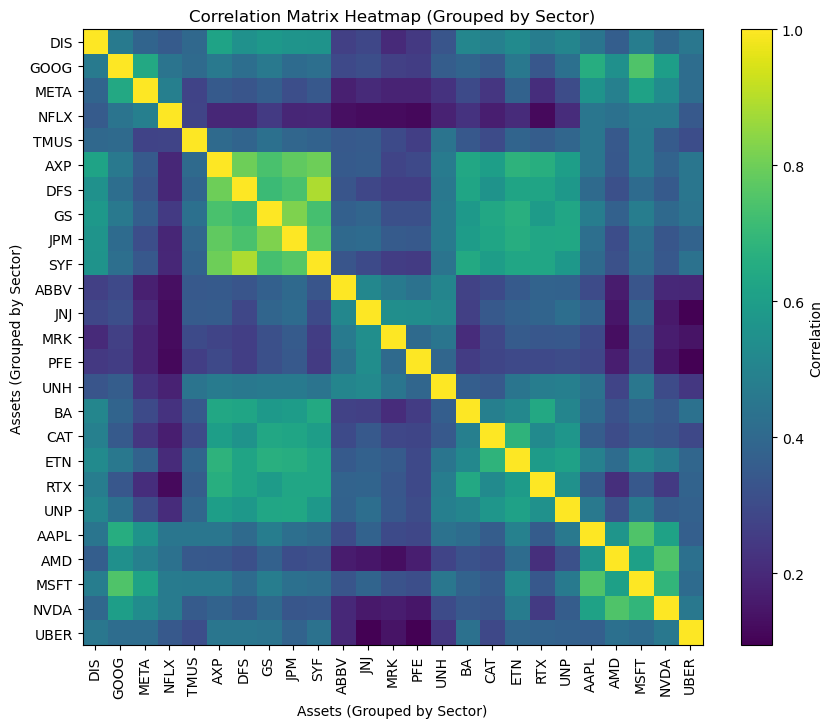

In [6]:
### Compute Expected Returns and Covariance Matrix ---
trading_days = 252  

# Compute expected daily returns
μ_daily = mean(returns_matrix, dims=1)
μ_daily = vec(μ_daily) 

# Annualize expected returns
μ = (1 .+ μ_daily) .^ trading_days .- 1

# Compute daily covariance matrix
Σ_daily = cov(returns_matrix, dims=1)

# Annualize covariance matrix
Σ = Σ_daily * trading_days

# Number of assets
n_assets = length(μ)

correlation_matrix = cor(returns_matrix)
sectors = [ticker_to_sector[ticker] for ticker in asset_names]

# Create a DataFrame to organize the assets and sectors
assets_df = DataFrame(Asset = asset_names, Sector = sectors)

# Sort the DataFrame by sector
assets_df = sort(assets_df, :Sector)

# Extract the reordered asset names and their indices
ordered_assets = assets_df.Asset
indices = [findfirst(x -> x == asset, asset_names) for asset in ordered_assets]

# Reorder the correlation matrix rows and columns by sector
reordered_correlation_matrix = correlation_matrix[indices, indices]

# Create the heatmap for the reordered correlation matrix
figure(figsize=(10, 8))
imshow(reordered_correlation_matrix, cmap="viridis", aspect="auto")
colorbar(label="Correlation")
title("Correlation Matrix Heatmap (Grouped by Sector)")

# Set tick positions and labels to reflect grouping by sectors
xticks(0:length(ordered_assets)-1, ordered_assets, rotation=90)
yticks(0:length(ordered_assets)-1, ordered_assets)

# Add axis labels
xlabel("Assets (Grouped by Sector)")
ylabel("Assets (Grouped by Sector)")

# Show the heatmap
show()


### Analysis of the Correlation Matrix Heatmap

This heatmap highlights correlations between assets grouped by sectors:

1. **Sector Clustering**: 
   - Assets within the same sector show high correlations (yellow clusters along the diagonal), such as Technology and Financial sectors.

2. **Inter-Sector Diversification**: 
   - Assets from different sectors generally exhibit lower correlations (green/blue areas), enhancing diversification.

3. **Diversified Sectors**: 
   - Sectors like Healthcare show weaker correlations with others, making them valuable for reducing portfolio risk.

4. **Low-Correlation Outliers**: 
   - Assets like **NFLX** (Communication Services) and **UBER** (Technology) have lower correlations, even within their sectors, making them useful hedges.

5. **Technology Overlap**: 
   - Technology assets show strong correlations both within and across sectors, suggesting caution to avoid concentration risk.

---

<a name="allocation-proportions"></a>
## 4.4. Allocation Proportions for Sectors and Assets

The goal of this part is to analyze the allocation of sector weights in each optimization models (MVO, Markowitz, Sharpe) using visualized pie charts, so as to reveal the influence of each model on industry selection and diversification strategy. Comparing the industry distribution of different models helps to more intuitively understand their trade-offs in weight concentration and dispersion.  
  
### Key Motivations include:  
1. Show the weighting priorities of different models in different industries.  
2. Compare the differences between the centralization and decentralization of the models in terms of industry weights.  
3. Three models (MVO, Markowitz, Sharpe) are used to explain the industry configuration characteristics driven by their respective optimization objectives.  


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



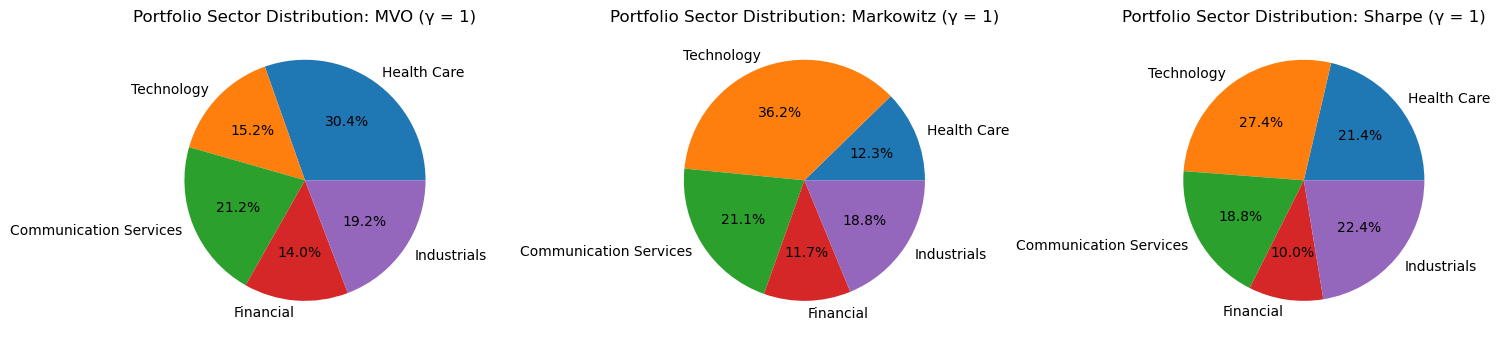

In [7]:
y = 1 # Gamma input
# Call the functions once and store the results
mvo_result = MVO(μ, Σ, y)
markowitz_result = Markowitz(μ, Σ, y)
sharpe_result = Sharpe(μ, Σ, y)

# Use the stored results to build the dictionary
portfolio_results = Dict(
    :MVO => (weights = mvo_result[1], ret = mvo_result[2], risk = mvo_result[3], sharperatio = mvo_result[4]),
    :Markowitz => (weights = markowitz_result[1], ret = markowitz_result[2], risk = markowitz_result[3], sharperatio1 = markowitz_result[4]),
    :Sharpe => (weights = sharpe_result[1], ret = sharpe_result[2], risk = sharpe_result[3], sharperatio = sharpe_result[4])
)


# --- Plotting Sector Weights for Each Model ---
model_order = [:MVO, :Markowitz, :Sharpe]

# Set up subplots: 1 row, number of models as columns
num_models = length(model_order)
fig, axes = subplots(1, num_models, figsize=(15, 6))  # Adjust figsize as needed

# Iterate through the models in the desired order
for (i, model_key) in enumerate(model_order)
    result = portfolio_results[model_key]
    
    # Calculate sector weights for the current model
    sector_weights = Dict()
    for (sector, indices) in sector_id
        total_weight = sum(result.weights[i] for i in indices)
        sector_weights[sector] = total_weight
    end

    # Plot pie chart on the corresponding subplot
    ax = axes[i]  # Select the subplot
    ax.pie(collect(values(sector_weights)), 
           labels=collect(keys(sector_weights)),
           autopct="%1.1f%%")
    title_text = "Portfolio Sector Distribution: $model_key (γ = $y)"
    ax.set_title(title_text)
    
end

# Adjust layout to prevent overlap and show the plots
tight_layout()
show()

### Key Observations

#### **<span style="color:blue;">MVO </span>**
- **Weight Distribution**:  
  The weight distribution is more focused on Health Care (30.4%) and Communication Services (21.2%), followed by Industrials (19.2%), Technology (15.2%), and Financial (14.0%), which accounts for the lowest proportion.
- **Analysis**:  
  The MVO model limits the concentration of sector weights through the penalty factor $\gamma$ and emphasizes diversification, allocating more weight to low-volatility sectors (e.g., Health Care and Communications Services).

#### **<span style="color:green;">Markowitz </span>**
- **Weight Distribution**:  
  The weight is concentrated in the Technology sector (36.2%), with Communication Services (21.1%), Industrials (18.8%), Health Care (12.3%), and Financial (11.7%), which accounts for the lowest share.
- **Analysis**:  
  The Markowitz model aims to maximize returns, assigning more weight to high-return sectors (e.g., Technology) but with less decentralization and greater concentration.

#### **<span style="color:red;">Sharpe </span>**
- **Weight Distribution**:  
  Skewed towards Technology (27.4%) and Health Care (21.4%), balanced by Industrials (22.4%), Communication Services (18.8%), and Financial (10.0%), which accounts for the lowest proportion.
- **Analysis**:  
  The Sharpe ratio model balances returns and diversification in optimizing risk-adjusted returns, favoring high Sharpe ratio sectors (e.g., Technology and Health Care) while maintaining some industry diversity.



### Comparison Summary

| **Model**                     | **Key Sectors**                       | **Weight Characteristics**                        | **Insights**                                       |
|--------------------------------|---------------------------------------|--------------------------------------------------|---------------------------------------------------|
| **<span style="color:blue;">MVO </span>**      | Health Care, Communication Services | Uniform, focuses on low-volatility sectors        | Diversifies weights amoung low correlated sectors effectively. |
| **<span style="color:green;">Markowitz </span>** | Technology, Communication Services    | Concentrated, favors high-return sectors          | High concentration in high return sectors.|
| **<span style="color:red;">Sharpe </span>**   | Technology, Health Care               | Balanced between high Sharpe ratio sectors        | Sharpe is balanced amoung all the models, it allocates a moderate amount to each sector|
---

Here we will use barplot visualizations for each model's sectors allocation to visualize the proportions for each asset.

sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


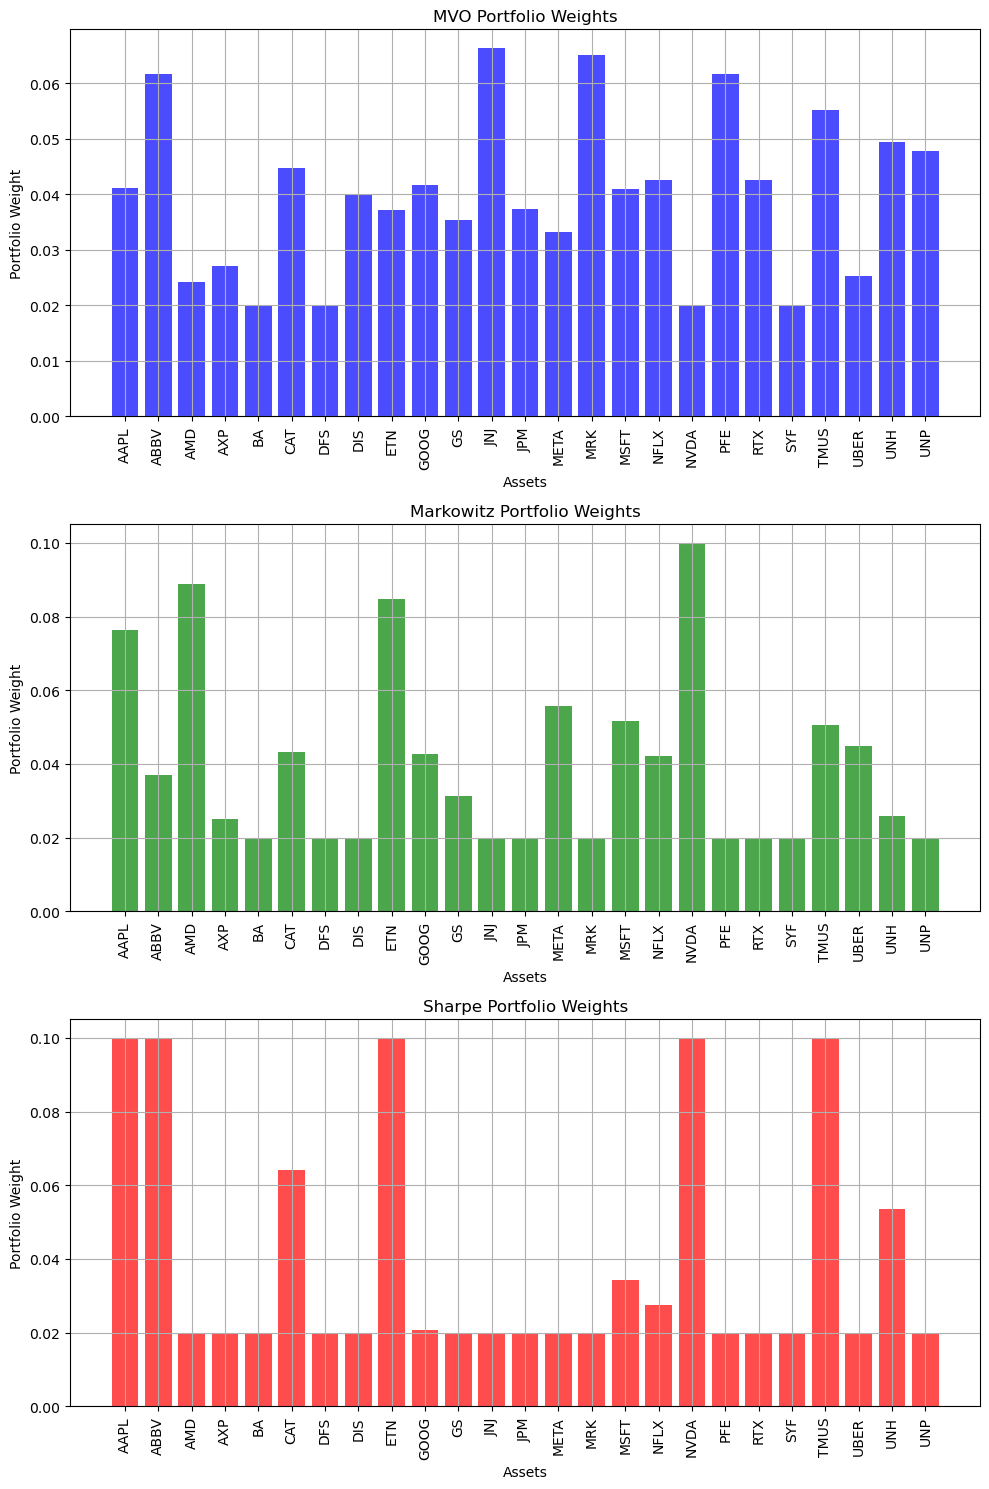

In [8]:
figure(figsize=(10, 15))  # Adjust the figure size for a vertical layout

# Colors for different portfolios
portfolio_names = collect(keys(portfolio_results))
model_order = [:MVO, :Markowitz, :Sharpe]
colors = ["blue", "green", "red"]  # Ensure the number of colors matches the number of portfolios

# Plotting the weights for each portfolio
for (i, model_key) in enumerate(model_order)
    subplot(length(portfolio_results), 1, i)  # Change to vertical layout
    portfolio_weights = portfolio_results[model_key][:weights]
    bar(1:n_assets, portfolio_weights, color=colors[i], alpha=0.7)
    xticks(1:n_assets, asset_names, rotation=90)
    xlabel("Assets")
    ylabel("Portfolio Weight")
    title("$model_key Portfolio Weights")
    grid(true)
    tight_layout()
end

show()


### Key Observations

#### **<span style="color:blue;">MVO </span>**
The MVO model exhibits the most balanced and diversified portfolio. This is evident from the relatively even distribution of asset weights, with most weights falling within the 4% to 6% range and very few assets at the minimum weight of 2%. An interesting observation is that all of the Health Care assets have the highest weights due to their low correlation with other sectors.

#### **<span style="color:green;">Markowitz </span>**
Compared to the MVO model, the Markowitz model is less diversified. There are more assets at the minimum investment level of 2%, indicating a higher concentration of weights in fewer assets.

#### **<span style="color:red;">Sharpe </span>**
The Sharpe Ratio model demonstrates the least diversification among all models. The portfolio is heavily concentrated in a few high-equity assets, as seen in the sharp peaks where weights reach a maximum of 10%, while the majority of assets remain at the minimum investment of 2%.

---

<a name="cumulative-weight-analysis"></a>
## 4.5. Cumulative Weight Distribution Analysis


The goal of a **Cumulative Weight Distribution** is to visualize the weight allocation of each optimization model to stock assets through the cumulative weight distribution diagram. This helps to further understand the priority and diversification characteristics of each model in asset selection. Different models' trade-offs between risk and return can lead to differences in stock weight distributions, which reflect the model's optimization strategy and actual effects.

### Key Motivations:
  1. The cumulative distribution of weights after visual ordering can clearly show how weights are assigned by different models.
  2. Observe whether the model's weight distribution of assets is concentrated on a small number of high-weight assets, or distributed across multiple assets.
  3. Compare the similarities and differences in the cumulative weight distribution of the three models to reveal their different preferences for return and diversification.

### Code Logic
1. **Data Processing**:
   - The code first extracts the stock weights for each model from the optimization results.
   - Ranks stocks by weight from highest to lowest, ensuring that assets with higher weights appear first in the cumulative distribution.
2. **Plotting**:
   - Three subgraphs are generated, corresponding to the cumulative weight distribution of the **<span style="color:blue;">MVO</span>**, **<span style="color:green;">Markowitz</span>**, and **<span style="color:red;">Sharpe</span>** models, respectively.
   - Each subgraph uses a different color (**blue**, **green**, **red**) to distinguish the models, and the stock labels are rotated for clear display.




sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


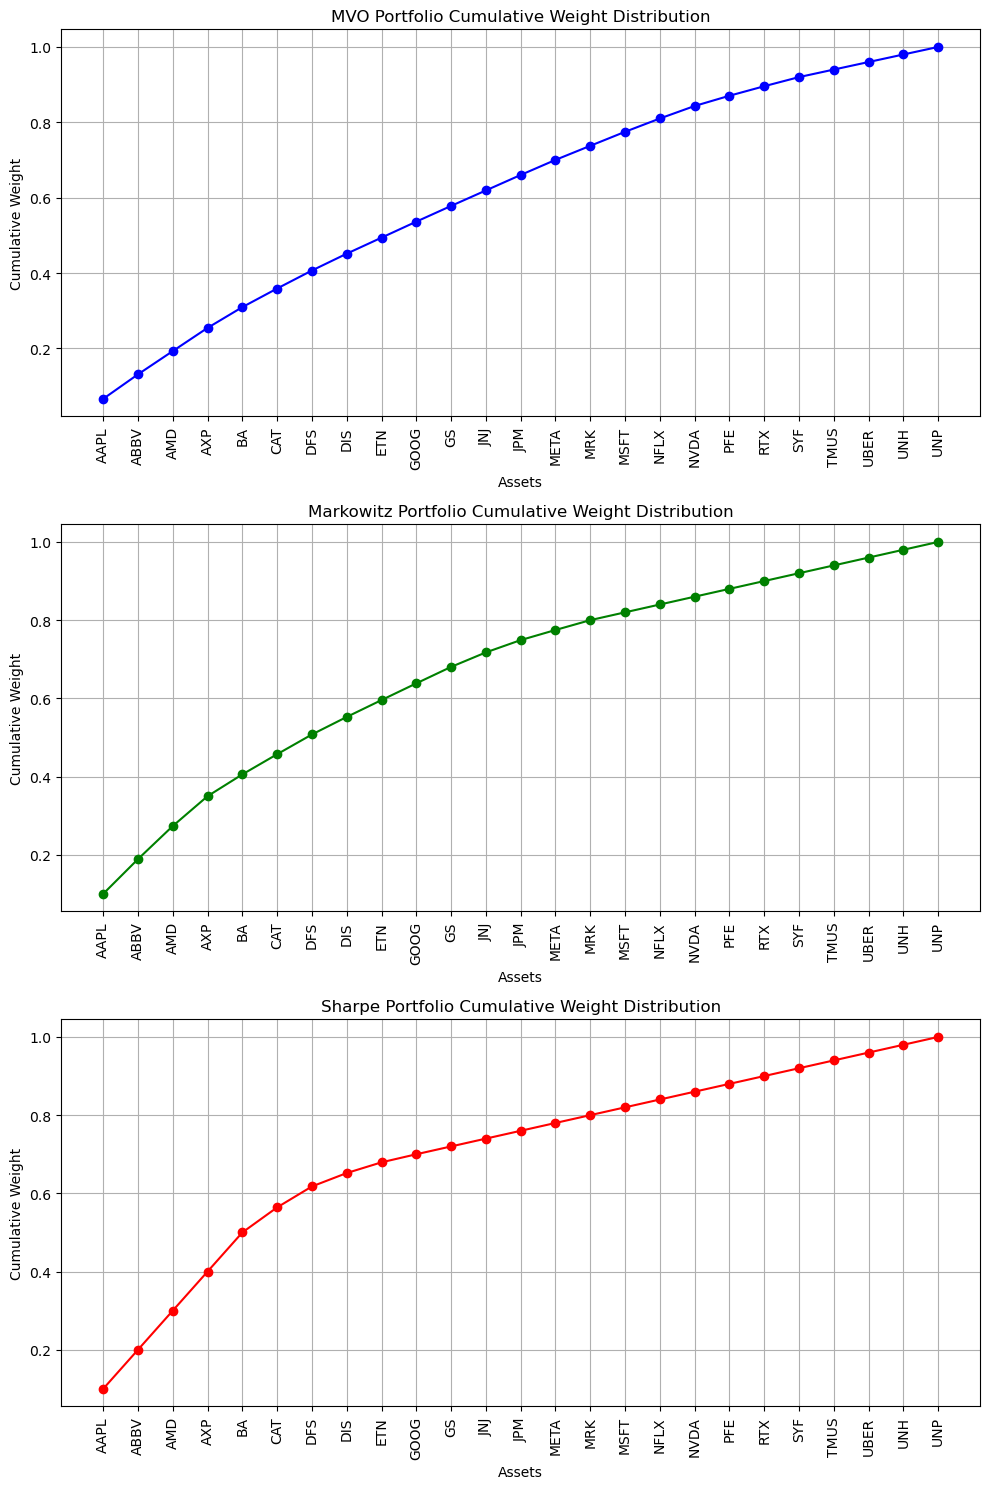

In [9]:
# --- Plotting Sector Weights for Each Model ---
model_order = [:MVO, :Markowitz, :Sharpe]
colors = ["blue", "green", "red"]

# Set up subplots: 1 row, number of models as columns
num_models = length(model_order)
figure(figsize=(10, 15)) 

# Iterate through the models in the desired order
for (i, model_key) in enumerate(model_order)
    subplot(length(portfolio_results), 1, i)
    portfolio_weights = portfolio_results[model_key][:weights]
    
    # Sort weights and calculate cumulative distribution
    sorted_weights = sort(portfolio_weights, rev=true)
    cumsum_weights = cumsum(sorted_weights)

    # Plot cumulative distribution
    plot(1:length(sorted_weights), cumsum_weights, color=colors[i], marker="o", linestyle="-", label=model_key)
    xticks(1:length(sorted_weights))
    xticks(1:n_assets, asset_names, rotation=90)
    xlabel("Assets")
    ylabel("Cumulative Weight")
    title("$model_key Portfolio Cumulative Weight Distribution")
    grid(true)
    tight_layout()
    show()
end



### Key Observations

#### **<span style="color:blue;">MVO</span>**
- **Distribution Characteristics**:  
  The cumulative weight curve increases most gently, indicating that the weight distribution is more uniform. The weight of a single stock is low, and the weight difference between all stocks is small.
- **Analysis**:  
  The MVO model emphasizes diversification, limiting the weight of a single asset through the $ \gamma$ parameter. This results in the gentlest accumulation curve of the three.
- **Limitation**:  
  The MVO model focuses too much on minimizing risk, possibly at the expense of potentially high-yielding assets.

#### **<span style="color:green;">Markowitz </span>**
- **Distribution Characteristics**:  
  The cumulative weight curve rises rapidly in the first few stocks, showing that some stocks (e.g., APPL and ABBV) have significantly higher weights. The weight of subsequent stocks decreases rapidly (e.g., UNH and UNP) and is unevenly distributed.
- **Analysis**:  
  The Markowitz model is more focused on maximizing returns and, therefore, may tend to assign more weight to assets with high earnings expectations.
- **Limitation**:  
  Because the weighting is concentrated in a small number of high-return assets, the portfolio is riskier and vulnerable to the performance of a single asset.

#### **<span style="color:red;">Sharpe </span>**
- **Distribution Characteristics**:  
  The cumulative weight curve is steepest, indicating a concentration in a small number of high-risk-adjusted return assets (e.g., AMD and AXP).
- **Analysis**:  
  The Sharpe ratio model allocates more weight to assets with higher Sharpe ratios by optimizing risk-adjusted returns while appropriately taking diversification into account.
- **Limitation**:  
  The weight distribution is still too concentrated. Although both risk and return are considered, it relies heavily on high-risk-adjusted return assets and may ignore the potential of low-risk assets.



### Comparison Summary

| **Model**                     | **Diversification** | **Weight Concentration** | **Accumulation Curve Characteristics**              | **Type of Investor Applicable**                          |
|--------------------------------|---------------------|--------------------------|-----------------------------------------------------|----------------------------------------------------------|
| **<span style="color:blue;">MVO</span>**      | High                | Lowest                   | Smooth and gradual growth, indicating uniform distribution | investors who seek stable returns            |
| **<span style="color:green;">Markowitz</span>** | Medium             | Medium                    | Rapid growth in few stocks, uneven distribution | High-return-oriented investors            |
| **<span style="color:red;">Sharpe</span>**   | Low                 | Highest                  | Steep curve, concentrated on a few high Sharpe ratio assets | Investors who seek risk-adjusted returns |

---


<a name="diversification-sensitivity"></a>
## 4.6. Diversification Sensitivity Analysis

An **Diversification Sensitivity Analysis** explores the behaior of portfolio returns and variances under varying levels of diversifcation penalties (𝛾), also know as regularization [7]. The goal is to provide insights into how the different optimization models — Mean-Variance Optimization (MVO), Markowitz Optimziation, and the Sharpe Ratio Maximization — responds to changes in 𝛾 and how these repsonses manifest in terms of portfolio performance metrics.

Our key motivation for this analysis:
1. **Understanding Diversification Effects:**  
γ acts as a parameter for the diversification penalty described in each of our models, representing how much weight is placed on diversifying our portfolio. By analyzing varying values of 𝛾, we aim to observe how portfolios adabt in terms of return and variance across all 3 models
2. **Model Comparisions:**  
While all three models are grounded in optimization principles, their formulations lead to differeing portfolio composisions. This analysis seeks to compare the performances of each model and understand their suitability for differing market conditions
3. **Polynomial Fitting for Trend Insights:**  
The financial markets often exhibit nonlinear behaviors, and fitting a polynomial to the return and variance data provides a smooth representation of trends. This approach helps identify key patterns andoutliers that might not be evident from numerical data alone.
4. **Practical Applications:**  
For portfolio managers, understanding how different optimization frameworks repsonds to risk penalities aids in constructing portfolios that align with strategic investment goals.
---

<a name="return-analysis"></a>
## 4.6.1. Portfolio Return Analysis with Diversification Penalty

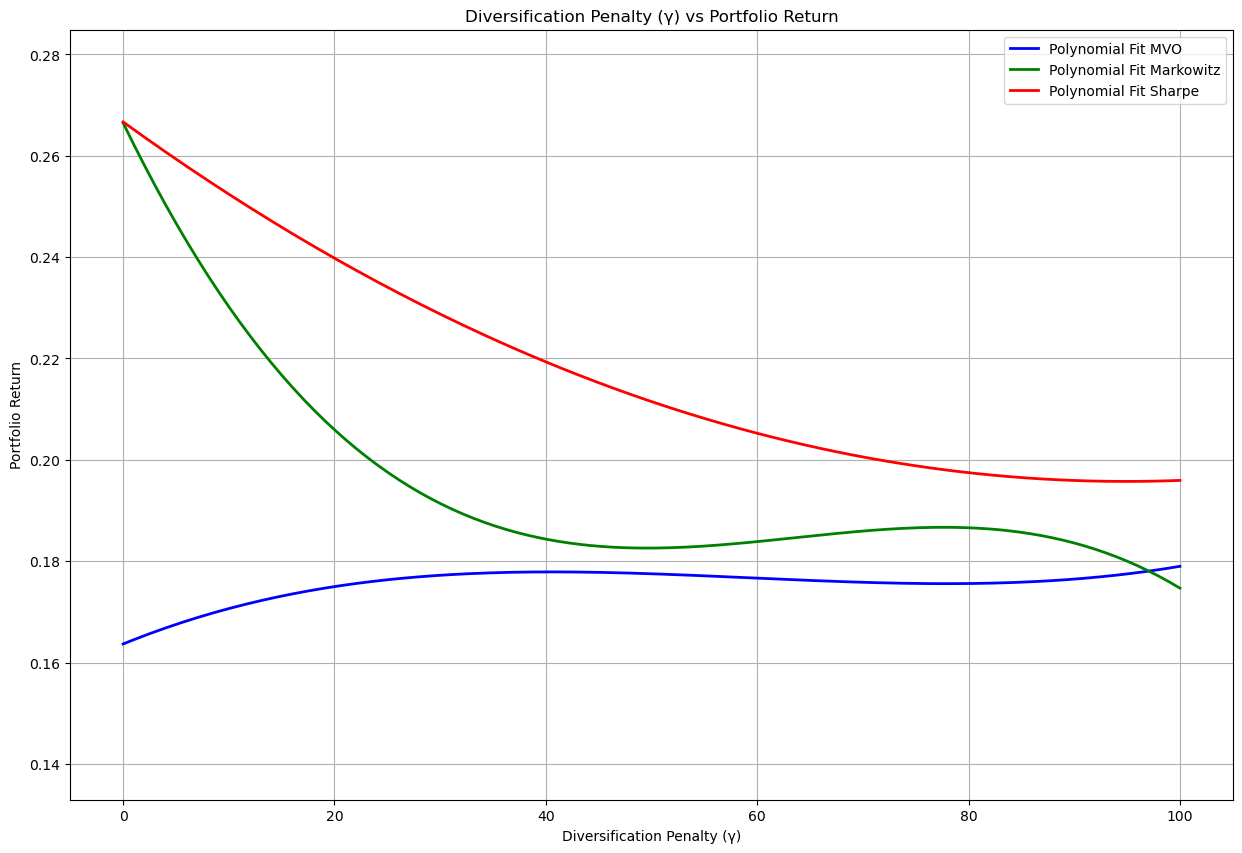

In [10]:
γ_values = 0:1:100
models = ["MVO", "Markowitz", "Sharpe"]
results = []

model_colors = Dict("MVO" => "blue", "Markowitz" => "green", "Sharpe" => "red")

# Collect results for each model and γ
for model in models
    for γ in γ_values
        port = eval(Symbol(model))(μ, Σ, γ)  # MVO and Sharpe use only γ
        if !isnothing(port)
            portfolio_weights, portfolio_return, portfolio_risk, sharpe_ratio = port
            portfolio_variance = portfolio_risk^2  # Variance is the square of risk
            push!(results, (model, γ, portfolio_return, portfolio_variance))
        end
    end
end

# Create subplots for Portfolio Return and Portfolio Variance
figure(figsize=(15, 10))

# Plot 1: Portfolio Return
for model in models
    # Filter results for the current model
    model_results = filter(r -> r[1] == model, results)
    γ_vals = [r[2] for r in model_results]
    ret_vals = [r[3] for r in model_results]

    # Fit a polynomial to the data
    degree = 3
    X = hcat([γ_vals.^k for k in degree:-1:0]...)
    coeffs = X \ ret_vals

    # Polynomial function
    poly_fit = x -> sum(coeffs[i] * x^(degree - i + 1) for i in 1:length(coeffs))

    # Scatter plot and fitted polynomial
    scatter(γ_vals, ret_vals, alpha=0, color=model_colors[model])
    x_fit = range(minimum(γ_vals), stop=maximum(γ_vals), length=200)
    y_fit = [poly_fit(x) for x in x_fit]
    plot(x_fit, y_fit, label="Polynomial Fit $model", lw=2, color=model_colors[model])
end
xlabel("Diversification Penalty (γ)")
ylabel("Portfolio Return")
title("Diversification Penalty (γ) vs Portfolio Return")
legend()
grid(true)

### Key Observations

#### **<span style="color:blue;">MVO</span>**
- The portfolio return starts relatively low at around 16% annually but shows a slight upward trend as $\gamma$ increases. 
- This suggests that increasing diversification penalties initially lead to slightly better returns. However, as $\gamma$ increases further, the return stabilizes and converges to approximately 18% annually.

#### **<span style="color:green;">Markowitz</span>**
- The return initially starts high at 26% annually, but as $\gamma$ increases, the returns decrease rapidly and eventually converge to about 18% annually.
- This indicates that increasing diversification penalties lead to lower returns.

#### **<span style="color:red;">Sharpe</span>**
- The return starts high at around 26% annually, but as $\gamma$ increases, it gradually decreases and stabilizes at approximately 20% annually.
- This suggests that increasing diversification penalties lead to lower returns, but the impact is more moderate compared to the Markowitz model.



### Comparative Analysis

When comparing all three models:
- Returns are most stable with the MVO model, possibly because there is no term in the objective function that maximizes the returns.
- For the Markowitz and Sharpe models, returns follow the same trend of decreasing as the portfolio becomes more diversified.
- A decreasing trend in returns does not necessarily mean the portfolio selected by the model is "bad," as we do not yet know the variance for each function as the diversification parameter increases.



### Comparison Summary

| **Model**                     | **Trend with $ \gamma $**                     | **Insights**                                       |
|--------------------------------|--------------------------------------|---------------------------------------------------|
| **<span style="color:blue;">MVO</span>**       | Slight increase                    | Stable returns.      |
| **<span style="color:green;">Markowitz</span>** | Significant decrease, stabilizes | Sensitive to  $ \gamma $, disrupts high returns. |
| **<span style="color:red;">Sharpe</span>**    | Gradual decrease                   | Clear trend in returns vs diversification.             |

---

<a name="variance-analysis"></a>
## 4.6.2. Portfolio Variance Analysis with Diversification Penalty

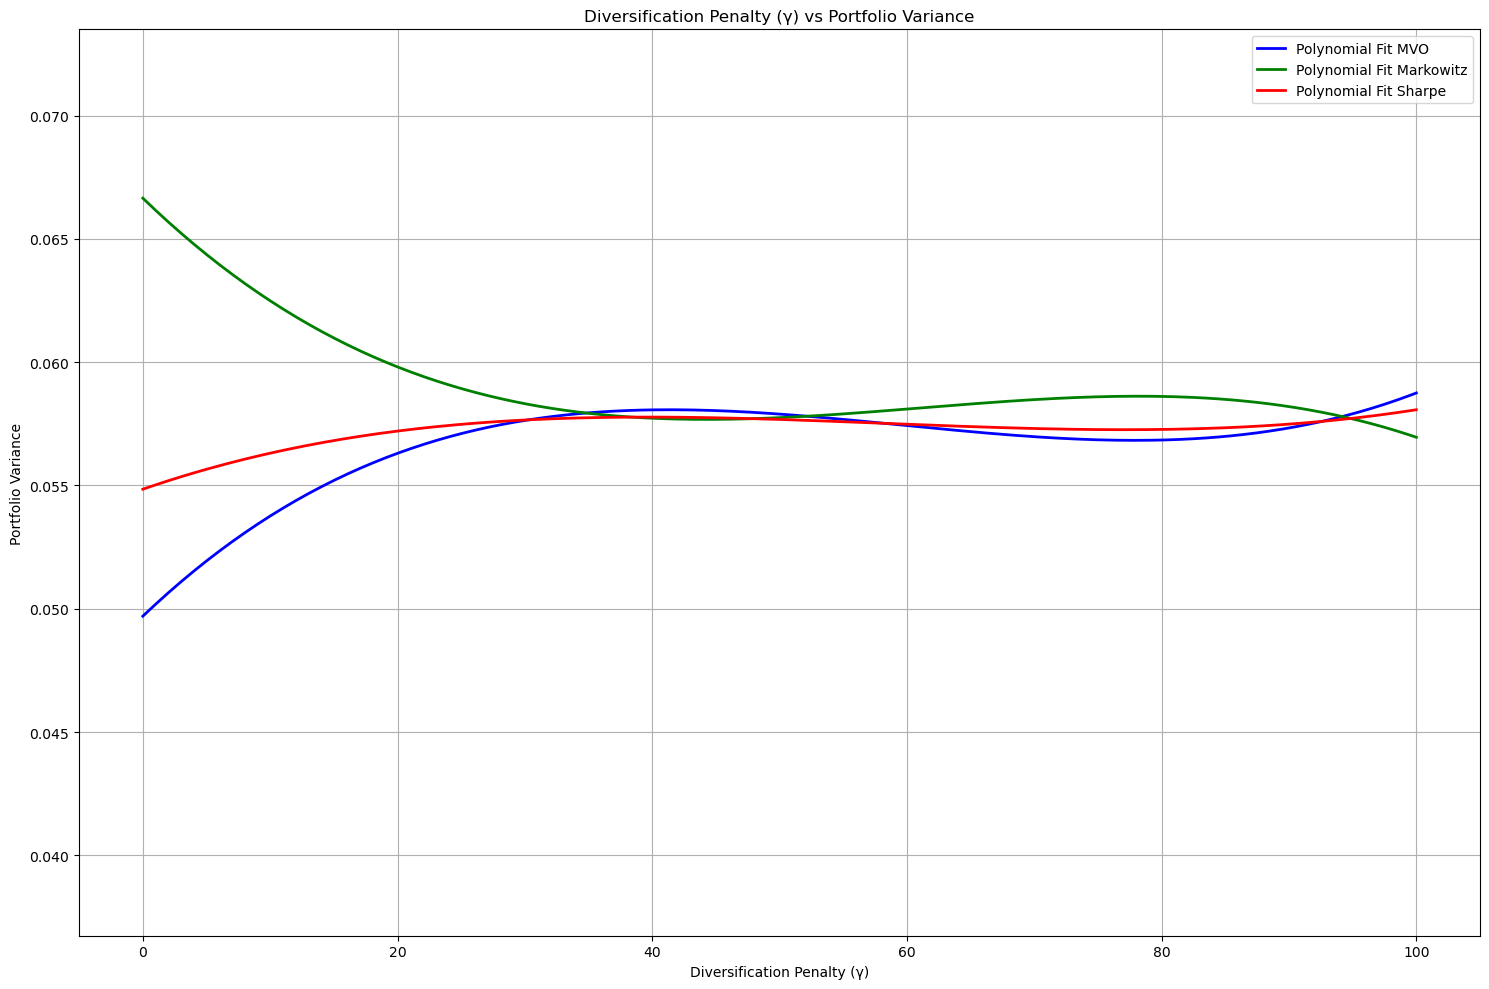

In [11]:
figure(figsize=(15, 10))

for model in models
    # Filter results for the current model
    model_results = filter(r -> r[1] == model, results)
    γ_vals = [r[2] for r in model_results]
    variance_vals = [r[4] for r in model_results]

    # Fit a polynomial to the data
    degree = 3
    X = hcat([γ_vals.^k for k in degree:-1:0]...)
    coeffs = X \ variance_vals

    # Polynomial function
    poly_fit = x -> sum(coeffs[i] * x^(degree - i + 1) for i in 1:length(coeffs))

    # Scatter plot and fitted polynomial
    scatter(γ_vals, variance_vals, alpha=0, color=model_colors[model])
    x_fit = range(minimum(γ_vals), stop=maximum(γ_vals), length=200)
    y_fit = [poly_fit(x) for x in x_fit]
    plot(x_fit, y_fit, label="Polynomial Fit $model", lw=2, color=model_colors[model])
end
xlabel("Diversification Penalty (γ)")
ylabel("Portfolio Variance")
title("Diversification Penalty (γ) vs Portfolio Variance")
legend()
grid(true)

# Adjust layout and show the plots
tight_layout()
show()

### Key Observations

#### **<span style="color:blue;">MVO </span>**
- In this model, we observe a low variance of approximately $ 0.05 $ when the value of $ \gamma $ is small. 
- As $ \gamma $ increases, the variance gradually rises, eventually converging to about $  0.057 $ at $ \gamma = 40 $.
- This observation indicates that as the portfolio becomes more diversified, the variance increases.

#### **<span style="color:green;">Markowitz </span>**
- The variance starts high with this model at approximately $ 0.062 $ when $ \gamma $ is small.
- As $ \gamma $ increases, the variance decreases, eventually converging to around $ 0.057 $, which aligns closely with the MVO model.
- This suggests that as the portfolio becomes more diversified, the variance reduces.

#### **<span style="color:red;">Sharpe </span>**
- The variance starts at a moderate level, between the Markowitz and MVO models, at approximately $  0.055 $ when $ \gamma $ is small.
- As $ \gamma $ increases, the variance shows a slight upward trend, eventually converging to around $ 0.057 $ at $ \gamma = 40 $.
- This indicates that the Sharpe model demonstrates stability across both small and large $ \gamma $ values.



### Comparative Analysis

When comparing all three models:
- The variance for small $ \gamma $ values follows the order: **MVO < Sharpe < Markowitz**.
- While there are noticeable differences in variance for small $ \gamma $ values, as $ \gamma $ increases, all models converge to a variance of approximately $ 0.057 $.
- This level of variance is considered favorable for the selected assets, as it reflects the high value these assets bring, inherently resulting in higher variance.



### Comparison Summary

| **Model**           | **Trend with $ \gamma $**                     | **Insights**                                       |
|---------------------|--------------------------------------|---------------------------------------------------|
| **<span style="color:blue;">MVO </span>**       | Gradual increase                    |  Risk slowly rises as it is diversified.    |
| **<span style="color:green;">Markowitz </span>** | Significant decrease, stabilizes     | As $ \gamma $ increases, variance stabilizes.    |
| **<span style="color:red;">Sharpe </span>**    | Gradual increase, smooth trend       | Most stable model for variance for all $ \gamma $ values.         |

---


<a name="eff"></a>
## 4.7 Efficient Frontier Analysis

## Motivations

An **Efficient Frontier** is the set of optimal points that offer the highest expected return for a defined risk or lowest risk, given an expected return [6]. This graph can be visualized as risk vs return.

This code snippet explores **portfolio optimization** using the three models: Mean-Variance Optimization (MVO), Markowitz, and Sharpe Ratio. The goal is to understand the impact of diversification penalties $ \gamma $ and a new input of target returns $ R_{\text{target}} $ on portfolio performance by comparing risk, return, and diversification.


## How the Code Works

### Portfolio Optimization Function
- **Inputs:**  
  - $ \mu $: Expected returns
  - $ \Sigma $: Covariance matrix
  - $ \gamma $: Diversification penalty
  - $ R_{\text{target}} $: Target return
  -  `model_type`: Optimization model.

- **Constraints:**
  - Asset weights: $ 0.02 \leq x \leq 0.1 $, Total allocation: $ \sum x = 1 $, Target return: $ \mu' \cdot x = R_{\text{target}} $.
  - Sector allocations restricted to 10–40%.

- **Objective Functions:**
  - **MVO:** Minimize variance and diversification penalty.
  - **Markowitz:** Maximize return minus risk (weighted by $ \lambda = 0.1$) and penalty.
  - **Sharpe Ratio:** Maximize risk-adjusted return while penalizing concentration.


### Iterative Optimization
- **Gamma Values $ \gamma $**: Test different diversification penalties to observe their effect.
- **Return Targets $ R_{\text{target}} $**: Range from 0.1 to 0.3.
- For each $ \gamma $, optimize for all models and return targets, storing risk and return data.

### Visualization
- Subplots for each $ \gamma $:
  - Risk (x-axis) vs. Return (y-axis).
  - Models are color-coded: MVO (blue), Markowitz (green), Sharpe Ratio (red).
- Highlights trade-offs between risk, return, and diversification across models and $ \gamma $.

## Expected Outcome

The plots provide insights into how different optimization models behave under varying levels of diversification penalties and target returns, offering a comparative view of their risk-return trade-offs.


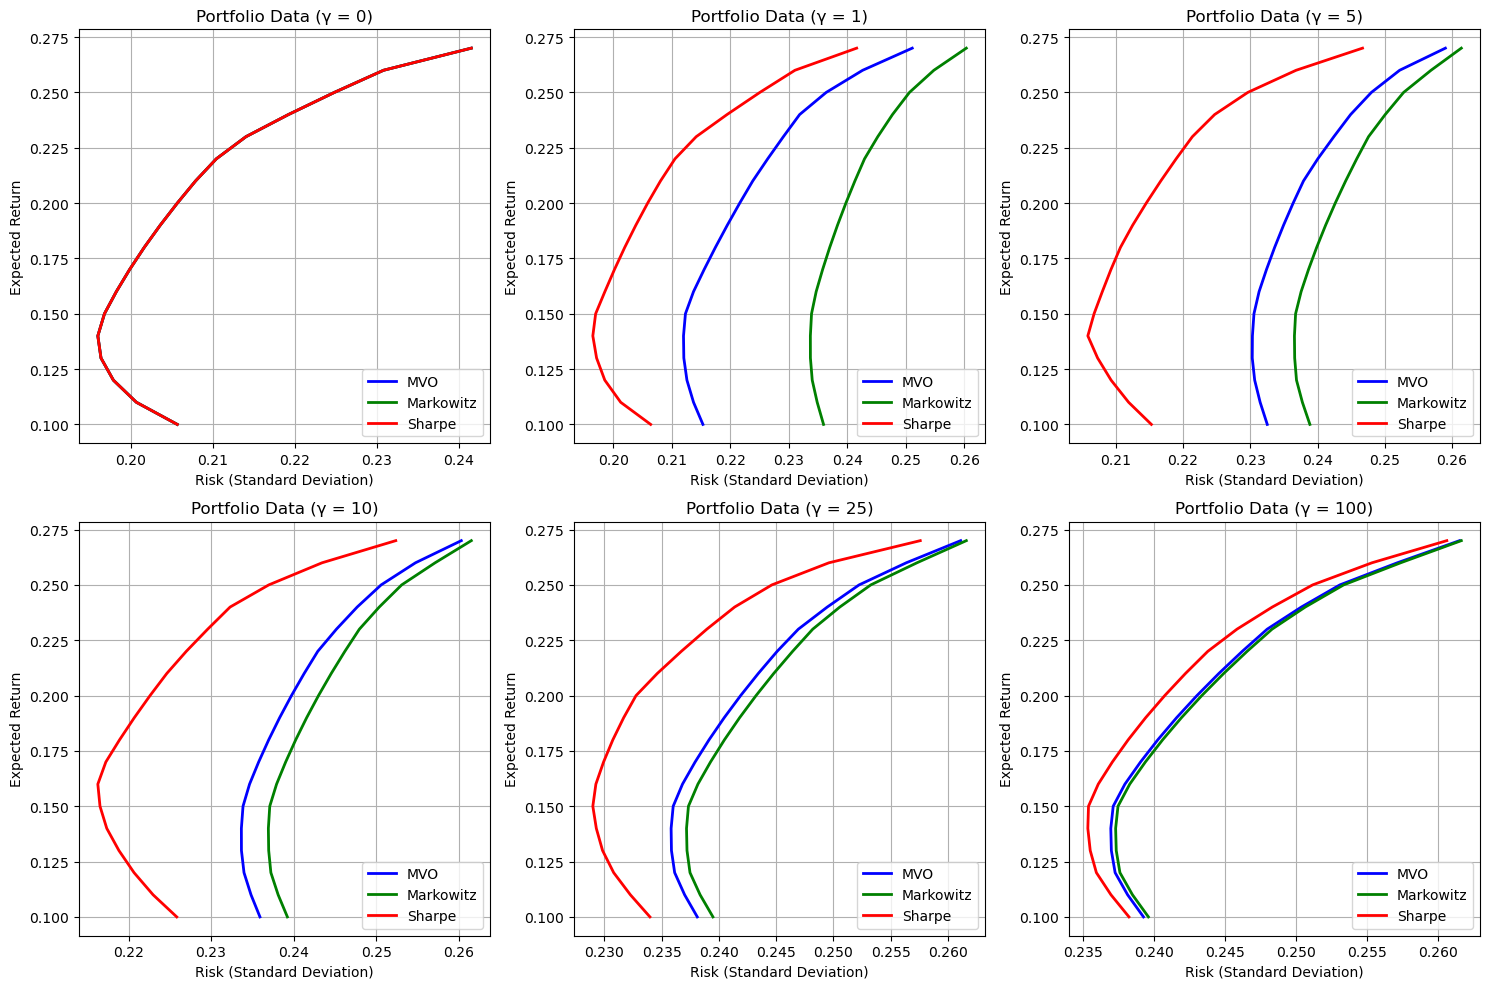

In [12]:
using Ipopt, JuMP, PyPlot, DataFrames

# Define the Portfolio Optimization Function
function optimize_portfolio(μ, Σ, γ, R_target, model_type::Symbol)
    # Create optimization model
    m = Model(Ipopt.Optimizer)
    set_optimizer_attribute(m, "print_level", 0)

    n_assets = length(μ)

    # Decision variables
    @variable(m, 0.02 <= x[1:n_assets] <= 0.1)  # Allocation bounds

    # Constraints
    @constraint(m, sum(x) == 1)  # Budget constraint
    @constraint(m, μ' * x == R_target)  # Target return constraint

    for (sector, indices) in sector_id
        @constraint(m, 0.1 <= sum(x[i] for i in indices) <= 0.4)
    end
    
    # Objective function
    if model_type == :mvo
        @objective(m, Min, x' * Σ * x + γ * sum(x[i]^2 for i in 1:n_assets))
    elseif model_type == :markowitz
        λ = 0.1
        @objective(m, Max, μ' * x - λ * (x' * Σ * x) - γ * sum(x[i]^2 for i in 1:n_assets))
    elseif model_type == :sharpe
        r_f = 0  # Risk-free rate
        @objective(m, Max, (μ' * x - r_f) / sqrt(x' * Σ * x) - γ * sum(x[i]^2 for i in 1:n_assets))
    else
        error("Invalid model type")
    end

    # Solve the model
    optimize!(m)
    status = termination_status(m)

    if status == MOI.OPTIMAL || status == MOI.LOCALLY_SOLVED
        portfolio_weights = value.(x)
        portfolio_return = μ' * portfolio_weights
        portfolio_risk = sqrt(portfolio_weights' * Σ * portfolio_weights)
        sharpe_ratio = portfolio_return / portfolio_risk
        return portfolio_weights, portfolio_return, portfolio_risk, sharpe_ratio
    else
        return nothing
    end
end

# Define Gamma Values and Return Targets
gamma_values = [0, 1, 5, 10, 25, 100]
#return_targets = range(0.1, 0.3, length=50)
return_targets = 0.1:0.01:0.3

# Models to Evaluate
models = [:mvo, :markowitz, :sharpe]
model_names = Dict(:mvo => "MVO", :markowitz => "Markowitz", :sharpe => "Sharpe")
model_colors = Dict(:mvo => "blue", :markowitz => "green", :sharpe => "red")

# Plotting with Subplots
figure(figsize=(15, 10))

for (i, γ) in enumerate(gamma_values)
    # Initialize DataFrame to Store Results
    results = DataFrame(risk=Float64[], ret=Float64[], model=String[])

    # Iterate Over Risk Targets and Apply Each Model
    for R in return_targets
        for model in models
            result = optimize_portfolio(μ, Σ, γ, R, model)
            if result !== nothing
                _, portfolio_return, portfolio_risk, _ = result
                push!(results, (portfolio_risk, portfolio_return, model_names[model]))
            end
        end
    end

    # Subplot for Current Gamma Value
    subplot(2, 3, i)
    title("Portfolio Data (γ = $γ)")

    # Plot All Data Without Filtering
    for model in unique(results.model)
        # Filter data for the current model
        model_data = filter(row -> row.model == model, results)

        # Plot All Points as a Line
        plot(model_data.risk, model_data.ret, label="$model", linewidth=2, color=model_colors[Symbol(lowercase(model))])
    end

    # Customize Each Subplot
    xlabel("Risk (Standard Deviation)")
    ylabel("Expected Return")
    legend(loc="lower right")
    grid(true)
end

# Adjust Layout and Show Plot
tight_layout()
show()


### Key Observations

#### **<span style="color:blue;">MVO </span>**
- The MVO model demonstrates a steady progression from low-risk, low-return portfolios to higher-risk, higher-return portfolios.
- At **low $ \gamma $** (e.g., $ \gamma = 0 $), the efficient frontier for MVO is the most conservative, remaining at the leftmost side of the plot, indicating strong emphasis on minimizing variance.
- As $ \gamma $ increases, the curve shifts rightward, slightly relaxing risk minimization to allow for higher returns. However, the overall risk-return trade-off remains controlled and gradual.

#### **<span style="color:green;">Markowitz </span>**
- The Markowitz model exhibits the steepest efficient frontiers at low $ \gamma $, prioritizing higher returns even at increased risk levels.
- With **higher $ \gamma $**, the frontier moves closer to MVO, as the diversification penalties reduce the model's focus on high-risk, high-return assets.
- By $ \gamma = 100 $, the Markowitz frontier almost overlaps with MVO, indicating a shift toward balanced diversification and risk control.

#### **<span style="color:red;">Sharpe </span>**
- The Sharpe model consistently provides the best risk-adjusted returns, dominating the other models across all $ \gamma $ values.
- At **low $ \gamma $**, the Sharpe model's curve remains higher on the return axis for the same risk levels, outperforming both MVO and Markowitz.
- As $ \gamma $ increases, the Sharpe model remains robust, showing minimal sensitivity to diversification penalties while maintaining superior performance.


### Comparative Analysis

When comparing the efficient frontiers:
- At **low $ (\gamma) $:**
  - **MVO:** Offers the 2nd lowest risk but at the cost of lower returns.
  - **Markowitz:** Has the steepest curve, reflecting its focus on return maximization but with higher risk.
  - **Sharpe:** Balances both, consistently outperforming MVO and Markowitz in terms of risk-adjusted returns.

- At **high $ (\gamma) $:**
  - All models converge slightly, as diversification penalties bring their risk-return trade-offs closer.
  - **Sharpe** maintains a slight dominance in risk-adjusted performance, while **MVO** and **Markowitz** show overlapping behavior, emphasizing diversification and risk control.


### Comparison Summary

| **Model**           | **Trend with $ \gamma $**            | **Insights**                                       |
|----------------------|----------------------------------------|---------------------------------------------------|
| **<span style="color:blue;">MVO </span>**       | Gradual shift to higher risk          | Emphasizes risk minimization; less sensitive to returns. |
| **<span style="color:green;">Markowitz </span>** | Converges to MVO at high $ \gamma $ | Prioritizes returns at low $ \gamma $, balances risk at high $ \gamma $. |
| **<span style="color:red;">Sharpe </span>**    | Minimal change across $ \gamma $    | Consistently achieves superior risk-adjusted returns.    |


### Insights from the Efficient Frontiers

- **Diversification Penalties $( \gamma) $:**  
  As $ \gamma $ increases, all models promote greater diversification, reducing risk concentration in high-return assets. This explains the gradual convergence of the curves.
  
- **Investor Preferences:**  
  - **Risk-averse investors** would prefer MVO for its conservative risk minimization.  
  - **Return-oriented investors** would favor Markowitz at lower $ \gamma $.  
  - **Balanced investors** would consistently benefit from Sharpe for its superior risk-adjusted performance.

- **Optimal Model:**  
  The Sharpe model outperforms across all scenarios, making it the most robust choice for portfolio optimization out of all the models, when balancing risk and returns is a priority.


<a name="limit"></a>
## 4.8 Limitations

### Model Limitations

- **<span style="color:blue;">MVO </span>**
  - Low Return Potential: The returns may be low, and it is difficult to adapt to the needs of high-return strategies.  
  - Sensitivity to Inputs: Reliance on the historical covariance matrix and expected returns makes the model highly sensitive to estimation errors, leading to potential inaccuracies in portfolio construction.

- **<span style="color:green;">Markowitz </span>**
  - High-Risk Concentration: If risk control is insufficient, there may be too much concentration in high-risk assets.  
  - Limited Diversification: Without sufficient control on diversification, the portfolio might fail to balance between different asset classes effectively.

- **<span style="color:red;">Sharpe </span>**  
  - Moderate Performance: Balance results in insufficiently extreme returns and risk performance, making it difficult to achieve excess returns under extreme market conditions.  
  - Sensitivity to Risk-Free Rate: Assumptions about the risk-free rate significantly impact portfolio weights.

---

### Approach Limitations

1. **Static Covariance Matrix:**  
   In our model, we assume the covariance matrix remains constant. In reality, market conditions, economic events, and other factors cause it to change over time. Relying on a static covariance matrix makes the model less reliable for future portfolio decisions, as it doesn't account for fluctuations in asset relationships driven by external factors.

2. **Overfitting to Polynomial Trend:**  
   Using polynomial fitting to model the relationship between the diversification penalty $( \gamma )$ and portfolio variance/returns can lead to overfitting. Higher-degree polynomials may capture noise in the data rather than the true underlying relationship. This can create misleading insights, as the model becomes too tailored to past data, potentially distorting the expected performance of the portfolio in the future.

3. **Simplification of Model Differences Over Time:**  
   In the current model, $ \gamma $ is treated as a fixed, static value. This simplification ignores market volatility, which can vary significantly over time. In reality, $ \gamma $ should increase during periods of high volatility to better manage risk. By assuming that changes in $ \gamma $ affect the model uniformly, we overlook the dynamic nature of optimization criteria. As a result, the optimization outputs may not be fully comparable across different market conditions.


<a name="conclusion"></a>
# 5. Conclusion

### Summarize

Below is a comparative analysis of the **MVO Model**, **Markowitz Model**, and **Sharpe Ratio Model**, highlighting their differences in optimization objectives, risk control, and asset distribution:

| Character                     | **<span style="color:blue;">MVO </span>**                                                                                               | **<span style="color:green;">Markowitz </span>**                                                                            | **<span style="color:red;">Sharpe </span>**                                                                                 |
|-------------------------------|---------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------|
| **Optimization Objective**    | Minimize portfolio variance while introducing diversification penalties $ \gamma $ to balance diversification with risk control. | Maximize expected returns minus the cost of risk, focusing more on the potential of high-yielding assets. | Maximize risk-adjusted return (Sharpe ratio), pursue a balance of return and risk, and add diversification penalties $ \gamma $. |
| **Risk Control**              | Strict risk control is achieved by directly minimizing the variance of the portfolio, and the weight of a single asset is limited. | The influence of risk on the optimization objective is adjusted by weight $ \lambda $, but the risk control is weak. | The Sharpe ratio formula automatically balances risks and returns, emphasizes risk-adjusted returns, and has strong risk control ability. |
| **Asset Distribution**        | The highest degree of nonvariance, with weights evenly distributed across multiple assets to reduce concentration risk. | Favoring high-return assets, concentrated distribution may lead to a single asset selection and a low degree of diversification. | It is biased towards the weight distribution of assets with risk-adjusted returns, and the degree of diversification is moderate. |
| **Application Scenario**      | Suitable for risk-averse investors who seek stable returns and prefer a diversified portfolio of low-risk assets. | Suitable for high-return-oriented investors, can tolerate high risk, the goal is to maximize the return of the portfolio. | Suitable for investors who seek risk-adjusted return and prefer balanced investments, seeking a compromise between stability and return. |
| **Key Advantage**             | - Strictly control risks and emphasize diversification;<br> - Can adapt to a wide range of market fluctuations. | - Maximizing earnings potential and focusing on high-return assets;<br> - Offers the possibility of higher rates of return. | - Balance returns and risks, adapt to investors with different risk preferences;<br> - Emphasize the distribution of assets with high Sharpe ratios. |
| **Limitation**                | The returns may be low, and it is difficult to adapt to the needs of high returns. | If risk control is insufficient, there may be too much concentration in high-risk assets. | Balance results in insufficiently extreme returns and risk performance to make it difficult to achieve excess returns under extreme market conditions. |

## Future Direction and Follow-up

### 1. Explore combinatorial optimization between models
- We have analyzed the MVO, Markowitz and Sharpe Ratio models separately, each with different advantages and disadvantages. In the future, we can try to combine the optimization results of these three models to build a multi-model integrated optimization framework, combining the advantages of each model, so as to achieve a more robust and flexible portfolio.

#### Specific ideas
- Assign a weight to each model (e.g. $ w_{\text{MVO}} ,  w_{\text{Markowitz}} ,  w_{\text{Sharpe}} $). According to these weights, the portfolio weights of the three models are integrated.
- Under the integration model framework, the optimization objective is redefined, which should not only integrate the risk-return characteristics of each model, but also ensure the stability of the results in practical application.
- Market indicators (such as interest rates, or Volume) are introduced as a reference for adjustments to ensure the flexibility of the integrated model.
- Test the stability of the integrated optimization framework in different market environments, such as high volatility markets.

#### Expected results
- Leverage the diversification of the MVO model, the high return potential of the Markowitz model, and the balance of the Sharpe Ratio model to improve the performance of the overall portfolio.
- Reduce the risk of a single model underperforming under specific market conditions and enhance portfolio robustness.

---

### 2. Dynamic optimization framework based on time dimension
- In this project, we used a fixed custom variety Diversification Penalty parameter $ \gamma $ to evaluate the performance of each optimization model. However, the market environment is dynamic, such as volatility indicators can significantly affect the correlation of assets and investors' risk appetite. Therefore, an feasible follow-up is to develop a method for dynamically adjusting $ \gamma $ based on market volatility in a specific time dimension, so that the optimization model can better adapt to actual market conditions.

#### Specific ideas
1. **The introduction of market volatility indicators and time series rolling window:**
   - Use CBOE Volatility Index (^VIX), Historical Volatility and so on to quantify the current state of volatility in the market.
   - In a high Volatility environment, $ \gamma $ values are automatically raised to enhance diversification and thus reduce risk; In a low volatility environment, the $ \gamma $ value is automatically lowered to concentrate more on higher return assets.
   - The rolling time window method (e.g., weekly, monthly, yearly...) is used to calculate the yield rate, covariance matrix and $ \gamma $ for each time period.

2. **Dynamic parameter $ \gamma $ adjustment algorithm [5]:**
   - **Relationship between volatility and $ \gamma $:** Based on historical market data, analyze the impact of volatility on portfolio performance and establish a relationship between $ \gamma $ and volatility. For example, for every 5 points increase in the VIX, the $ \gamma $ value increases by a certain percentage.
   - **Real-time dynamic update:** Within each time window, the $ \gamma $ value required for the current optimization is dynamically calculated based on the latest market volatility indicator.
   - **Dynamic optimization objective function:** At each optimization, the updated $ \gamma $ value is plugged into the model to generate a portfolio that is better suited to the current market environment.

3. **Mechanism:**
   - **Rolling Time Window:** The current expected return, covariance matrix, and Diversification penalty parameter are calculated by rolling over a fixed length of time window (such as weekly or monthly).
   - **Data update and input calculation:** Update asset prices, yields, etc., based on the latest data within the time window, and calculate new optimized input parameters.
   - **Run the optimized model:** Within each time window, run the MVO, Markowitz, or Sharpe ratio model with the currently updated parameters to determine the optimal asset allocation weight.
   - **Adjust portfolio weights:** Adjust portfolio weights based on optimization results to ensure compliance with established constraints.
   - **Cycle repeat:** Each new time window, rolling update the data and repeat the above steps to continuously optimize the portfolio.

#### Expected results
1. **Model performance improvement:**
   - The dynamic adjustment mechanism can ensure that the model has strong flexibility under different market conditions.
     - In a highly volatile environment, the risks of the portfolio are effectively controlled and show higher stability.
     - In a low volatility environment, the returns of the portfolio are significantly improved and can capture the return opportunities of the market.

2. **Reduce the risk of overfitting:**
   - Compared to static models optimized with fixed historical data, dynamic optimization frameworks are better able to avoid overfitting data over a single time period.

3. **Risk diversification and stable returns:**
   - Dynamically adjusting the concentration and diversification of assets can find a better balance between risk and return.

4. **Optimization on multiple time scales:**
   - In a dynamic optimization framework, optimization can be performed on multiple time scales, such as:
     - Short-term optimization: Make short-term revenue forecasts based on the 1 week or 1 month data.
     - Long-term optimization: Stable asset allocation based on six months or one year of data.


<a name="contributions"></a>
# 6. Author Contributions

#### 1. Modelling  
Vincent: Percentage contribution 34%  
Pawin: Percentage contribution 33%  
Jiajie: Percentage contribution 33%  

  
#### 2. Analysis  
Vincent: Percentage contribution 34%  
Pawin: Percentage contribution 33%  
Jiajie: Percentage contribution 33%  


#### 3. Data Gathering  
Vincent: Percentage contribution 30%  
Pawin: Percentage contribution 30%  
Jiajie: Percentage contribution 40%  


#### 4. Software Implementation  
Vincent: Percentage contribution 30%  
Pawin: Percentage contribution 35%  
Jiajie: Percentage contribution 35%  


#### 5. Report Writing    
Vincent: Percentage contribution 33%  
Pawin: Percentage contribution 33%  
Jiajie: Percentage contribution 34%  

<a name="references"></a>
# 7. References

1. Team, T. I. (2023, August 29). Modern portfolio theory: What MPT is and how investors use it. Investopedia. https://www.investopedia.com/terms/m/modernportfoliotheory.asp?utm_source=chatgpt.com

2. Team, T. I. (2023, August 29). Sharpe Ratio: Definition, Formula, and Examples. Retrieved from https://www.investopedia.com/terms/s/sharperatio.asp

3. Team, T. I. (2023, August 29). Mean-Variance Optimization (MVO): Definition and Examples. Investopedia. https://www.investopedia.com/terms/m/meanvariance-analysis.asp

4. Fabozzi, F. J., Gupta, F., & Markowitz, H. M. (2002). The Legacy of Modern Portfolio Theory. The Journal of Investing, 11(3), 7-22. https://doi.org/10.3905/joi.2002.319510

5. Engle, R. F. (1982). Autoregressive conditional heteroscedasticity with estimates of the variance of United Kingdom inflation. Econometrica, 50(4), 987–1007. https://doi.org/10.2307/1912773

6. Team, A. (2024, September 21). Efficient Frontier in portfolio management: Concepts, Techniques, and applications. Accounting Insights. https://accountinginsights.org/efficient-frontier-in-portfolio-management-concepts-techniques-and-applications/

7. Rebonato, R., & Denev, A. (2014). Diversification in Modern Portfolio Theory. In Portfolio Management under Stress: A Bayesian-Net Approach to Coherent Asset Allocation (pp. 55–70). chapter, Cambridge: Cambridge University Press.